In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import scipy.sparse
import os
# helpers.py is one level up in the directory structure so we need to tell Python were to find it
import sys
sys.path.append("../../")
import helpers

# Gradient Based Image Blending
In this notebook you will implement gradient based image blending, which was originaly was described in the paper [Poisson Image Editing](https://www.cs.jhu.edu/~misha/Fall07/Papers/Perez03.pdf). The goal of gradient based image blending is to copy a region of one image (source image) into another image (target image) without creating visible seams at the edge of the region.

**NOTE** In this exercise, we implement a version of the gradient based image blending scheme that is a bit simpler than what was discussed in the lecture. The difference is that we do not need to distinguish between inner and boundary gradients but only need one gradient matrix for the region to be filled.

As was covered in the lecture, the idea behind gradient based image blending is to find new pixel values such that the gradients of the source image are retained while making sure that there is no visible seam at the boundary of the affected region. We will now define this more formally. Let $I$ denote the set of pixels of the region to be filled, $B$ the set of boundary pixels, and $g_i$ and $\tilde{g_i}$ the output and source gradients within the region to be filled.

$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = \sum\limits_{i \in I} {\lvert g_i - \tilde{g_i} \rvert}^2 + c_{\tilde{u}} \sum\limits_{i \in B} {\lvert U - \tilde{U_t} \rvert}^2
\end{align}
$$

We can rewrite $f(U)$ using only matrix operations. Let $S$ be the selector matrix which selects all pixels on the boundary, $U$ the vector containing the output pixel values (in the region to be filled), $\tilde{U_s}$ the source pixel values (in the region to be filled) and $\tilde{U_t}$ the target pixel values (in the region to be filled). Let $G$ be the gradient matrix for the region to be filled. With the the gradient defined as  $g=GU$ we can derive the following quadratic polynomial:

$$
\begin{align}
f(U) &= {\lvert GU - G\tilde{U_s} \rvert}^2 + c_{\tilde{u}} {\lvert SU - S\tilde{U_t} \rvert}^2 \\
f(U) &= (U^TG^T - \tilde{U_s}^TG^T) (GU-G\tilde{U_s}) + c_{\tilde{u}} (U^TS^T - \tilde{U_t}^TS^T)(SU - S\tilde{U_t}) \\
f(U) &= U^T(G^TG)U - 2U^T(G^TG\tilde{U_s}) + \tilde{U_s}^TG^TG\tilde{U_s} + c_{\tilde{u}} (U^TS^TSU - 2U^TS^TS\tilde{U_t} + \tilde{U_t}^TS^TS\tilde{U_t}) \\
f(U) &= U^T(G^TG + c_{\tilde{u}} S^TS)U - 2U^T(G^TG\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t}) + \tilde{U_s}^TG^TG\tilde{U_s} + c_{\tilde{u}} \tilde{U_t}^TS^TS\tilde{U_t} \\
\end{align}
$$

We want to minimize this objective function which is when the derivative is zero $f'(U)=0$. Using this knoweldge we can transform the problem into a linear system:

$$
\begin{align}
f'(U) &= 2(G^TG + c_{\tilde{u}} S^TS)U - 2(G^TG\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t}) = 0 \\
(G^TG + c_{\tilde{u}} S^TS)U &= G^TG\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t} \\
%(L + c_{\tilde{u}} S^TS)U = L\tilde{U_s} + c_{\tilde{u}} S^TS\tilde{U_t}
\end{align}
$$

### Initialization
The following code loads the images that we will use for the image blending exercises.

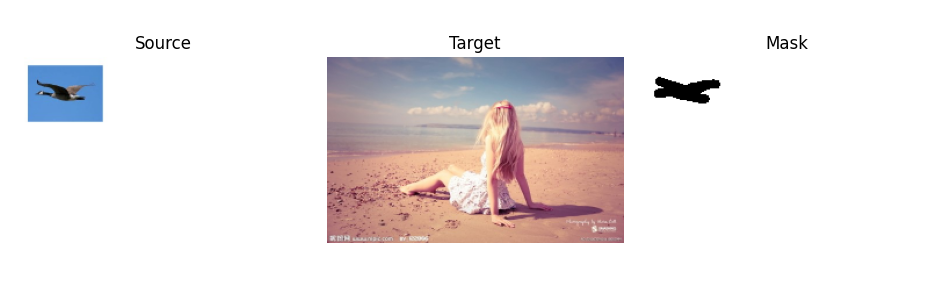

In [2]:
swan_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "swan.jpg"), 0.5)
beach_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "beach.jpg"), 0.5)
swan_beach_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "mask.jpg"), 0.5)
swan_beach_mask = (swan_beach_mask < 0.5)

helpers.show_images({ "Source": swan_image_color, "Target": beach_image_color,  "Mask": swan_beach_mask}, nrows=1, ncols=3)

## Exercise 3 (2 points)
Implement a function that returns the gradient matrix $G$. Note that the image vector $U$ now only contains pixels *inside* the mask (`mask[y,x] == 0`), and the gradient vector $g$ only contains the partial derivatives between pixels *inside* the mask. *Refer to the image sharpening notebook for more information on gradients.*.

You may assume that the masked region does *not* touch the edge of the image.

In [83]:
def construct_G(mask):
    # TODO 1: Compute the correct number of rows and columns in the gradient matrix
    
    black_pixels = np.sum(mask == 0)
    num_columns = black_pixels
    num_rows = 0
    index_matrix = np.zeros(mask.shape)
    pixel_count = 0
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1] - 1):
            if mask[y, x] == 0:
                index_matrix[y, x] = pixel_count
                pixel_count += 1
                if mask[y, x + 1] == 0:
                    num_rows += 1
    for x in range(mask.shape[1]):
        for y in range(mask.shape[0] - 1):
            if mask[y, x] == 0:
                if mask[y + 1, x] == 0:
                    num_rows += 1 
                    

    G = scipy.sparse.lil_matrix((num_rows, num_columns))
    # TODO 2: Fill the gradient matrix G with the correct values (0.5 and -0.5).
    row = 0
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1] - 1):
            if (mask[y, x], mask[y, x + 1]) == (0, 0):
                (index_l, index_r) = index_matrix[y, x], index_matrix[y, x + 1]
                G[int(row), int(index_l)] = -0.5
                G[int(row), int(index_r)] = 0.5
                row += 1
    for x in range(mask.shape[1]):
        for y in range(mask.shape[0] - 1):
            if (mask[y, x], mask[y + 1, x]) == (0, 0): 
                (index_l, index_r) = index_matrix[y, x], index_matrix[y + 1, x]
                G[int(row), int(index_l)] = -0.5
                G[int(row), int(index_r)] = 0.5
                row += 1
    
    # Convert scipy.sparse.lil_matrix to scipy.sparse.csr_matrix for efficient processing
    return scipy.sparse.csr_matrix(G)

### Testing your solution of exercise 3
This code visualizes the gradients generated by your $G$ matrix. With `construct_G` implemented it should show the gradient magnitudes of the bird image. The cell below checks that the gradient matrix you return has the correct type.

*Warning*: the visualization will crash if the gradient matrix does not have the correct shape!

In [14]:
print(construct_G(np.ones((4,4))))

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 0 stored elements and shape (0, 0)>


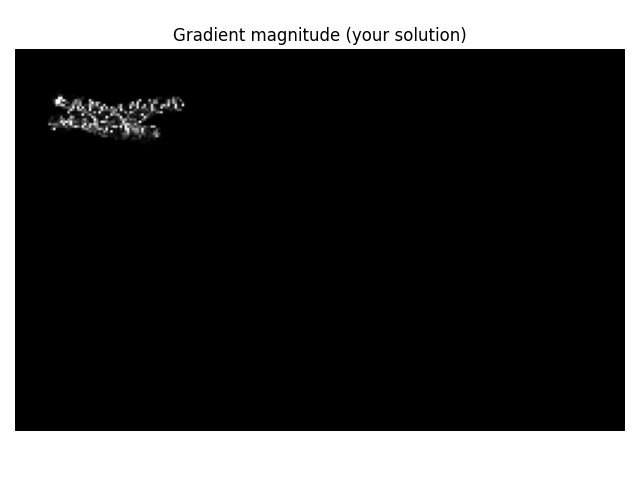

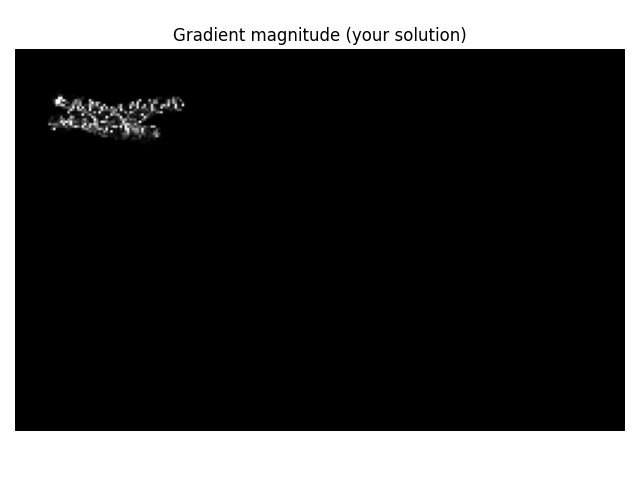

In [84]:
def construct_U(image, mask):
    indices = np.nonzero(np.invert(mask))
    return image[indices].flatten()

# Convert a gradient vector for a given mask into an image visualizing the gradient magnitude
def gradient_to_image(g, mask):
    out_image = np.zeros(mask.shape)
    
    # gx**2 at each pixel
    i = 0
    for (y, x) in zip(*np.nonzero(np.invert(mask))):
        if not mask[y, x+1]:
            out_image[y, x] += g[i]**2
            i += 1
            
    # gy**2 at each pixel
    for (y, x) in zip(*np.nonzero(np.invert(mask))):
        if not mask[y+1, x]:
            out_image[y, x] += g[i]**2
            i += 1
    
    return np.sqrt(out_image)

green_channel = swan_image_color[:,:,1]
G = construct_G(swan_beach_mask)
u = construct_U(green_channel, swan_beach_mask)
g = G * u

gradient_image = gradient_to_image(g, swan_beach_mask)

# Increase contrast to make it easier to spot the gradients
gradient_image = np.clip(5 * gradient_image, 0, 1)

helpers.show_image(gradient_image, "Gradient magnitude (your solution)")

In [85]:
# Create a 4x4 image filled with a 2x2 masked region
dummy_mask = np.ones((4,4)).astype(bool)
for y in range(1, 3):
    for x in range(1, 3):
        dummy_mask[y, x] = 0
G = construct_G(dummy_mask)
assert(type(G) == scipy.sparse.csr_matrix)
# 2x2 mask region => 4 pixels; 2 horizontal gradients + 2 vertical gradients.
assert(G.shape == (4, 4))
# The first horizontal gradient (between pixels 0 and 1)
assert(G[0,0] == -0.5)
assert(G[0,1] == 0.5)

# You can add more tests here.

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Exercise 4 (2 points)
We need a selector matrix $S$ which selects all pixels that are on the boundary of the mask. The selector matrix transforms the image vector $U$ (storing all pixels inside the mask) into a vector storing only the boundary values. Hence, the number of rows should match the number of boundary pixels and the number of columns should match the number of pixels inside the mask. Each row has exactly one entry (set to $1.0$) which corresponds to the selected pixel.

A pixel is inside the mask if `mask[y,x] == 0` and is on the boundary if any of it's 4-connected (left, top, right, bottom) neighbours is outside the mask.

**WARNING**: the grading script requires the entries of $S$ to be ordered in a specific way. Make sure that the boundary pixels are selected from left to right, and top to bottom.

In [ ]:
def construct_S(mask):
    # TODO 1: Compute the correct number of rows and columns in the selector matrix
    num_rows = 123 # REPLACE ME
    num_columns = 456 # REPLACE ME

    S = scipy.sparse.lil_matrix((num_rows, num_columns))
    # TODO 2: Fill the selector matrix S with the correct values.
    # YOUR CODE HERE
    return scipy.sparse.csr_matrix(S)

### Testing your solution of exercise 4
The matrix S should select the boundary pixels from the vector of masked pixels. We provide a basic test to check if the matrix you returned has the correct size.

In [ ]:
# Add your own tests here.

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL

## Exercise 5 (1 point)
We now have all the matrices required to formulate the linear system. To operate on color images, seamless cloning can be applied to each color channel individually. Implement a function that performs a seamless clone on a single color channel by solving the linear system described above (using `scipy.sparse.linalg.solve`). The inputs to this function are a single color channel of the source, target and mask images (all with the same shape) and $c_{\tilde{u}}$ to indicate the strength of the boundary constraint. The function should return the final result of that color channel (as a 2D numpy array).

**NOTE**: For grading we use the reference implementation of `construct_S()` and `construct_G()` to ensure that you are not punished for mistakes in the previous exercises.

In [ ]:
def seamless_clone_channel(source, target, mask, cu):
    # TODO: Perform seamless cloning as described in the exercise description.
    # YOUR CODE HERE
    return target.copy()
    
def seamless_clone(source_image, target_image, mask, cu):
    # Perform cloning along all three color channels.
    red_channel = seamless_clone_channel(source_image[:,:,0], target_image[:,:,0], mask, cu)
    green_channel = seamless_clone_channel(source_image[:,:,1], target_image[:,:,1], mask, cu)
    blue_channel = seamless_clone_channel(source_image[:,:,2], target_image[:,:,2], mask, cu)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)

result_image = seamless_clone(swan_image_color, beach_image_color, swan_beach_mask, 0.5)
result_image = np.clip(result_image, 0, 1)

helpers.show_image(result_image, "Seamlessly cloned image (your solution)")

### Testing your solution of exercise 5
After implementing exercise 5 the image above should show the girl on the beach with the bird filled in. The bird will appear yellow-ish to match the tone of the environment.

In [ ]:
# Add your own tests here.

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


# Extra Exercises (Mixed Gradients)
The previous exercises are enough to get you a passing grade. However, to get a $10$ you need to show that you have mastered the topic. Therefore, we introduce the following extra exercises which are considered a bit more challenging. You need to complete these without the help of the teaching assistants (TAs). **You not allowed to ask the TAs for help with the extra exercises**. However, you can report bugs by sending us an e-mail at `vdp-cs-ewi@tudelft.nl`.

The result of seamless cloning looks convincing when the masked region of the target image does not contain a lot of detail, like in the example images that we used above. However, when we apply the same technique to a highly textured target image then the result will look blurry. This happens because we completely ignore the targets gradients, replacing them by the source gradient. In this example most source gradients are close to zero (the drawing has a smooth background) meaning the linear system will smoothly interpolate between the boundaries.

In [ ]:
drawing_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "drawing.jpg"), 1)
sign_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "sign.png"), 1)
drawing_sign_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mask.jpg"), 1)
drawing_sign_mask = (drawing_sign_mask < 0.5)

result_color = seamless_clone(drawing_image_color, sign_image_color, drawing_sign_mask, 0.5)
result_color = np.clip(result_color, 0, 1)
helpers.show_image(result_color, title="Result")
helpers.show_images({ "Source": sign_image_color, "Target": drawing_image_color,  "Mask": drawing_sign_mask}, nrows=1, ncols=3)

If the source image has a flat background like in this example than we can improve the result by mixing the gradients of the source and target image. We modify the equation such that at each pixel we either use the source gradient $(g_x^s, g_y^s)$ or the target gradient $(g_x^t, g_y^t)$, whichever has the largest magnitude (L2 norm).

$$
\begin{align}
f(U) &= {\lvert GU - \tilde{V} \rvert}^2 + c_{\tilde{u}} {\lvert SU - S\tilde{U_t} \rvert}^2\\
f(U) &= (U^TG^T - \tilde{V}^T) (GU-\tilde{V}) + c_{\tilde{u}} (U^TS^T - \tilde{U_t}^TS^T)(SU - S\tilde{U_t}) \\
f(U) &= U^T(G^TG)U - 2U^T(G^T\tilde{V}) + \tilde{V}^T\tilde{V} + c_{\tilde{u}} (U^TS^TSU - 2U^TS^TS\tilde{U_t} + \tilde{U_t}S^TS\tilde{U_t}) \\
f(U) &= U^T(G^TG + c_{\tilde{u}} S^TS)U - 2U^T(G^T\tilde{V} + c_{\tilde{u}} S^TS\tilde{U_t}) + \tilde{V}^T\tilde{V} + c_{\tilde{u}} \tilde{U_t}S^TS\tilde{U_t} \\
\end{align}
$$

Here $\tilde{V}$ is the vector containing the selected gradients (similar to $\tilde{g}=G\tilde{U}$). To minimize the objective function we find where the derivative is zero:

$$
\begin{align}
f'(U) &= 2(G^TG + c_{\tilde{u}} S^TS)U - 2(G^T\tilde{V} + c_{\tilde{u}} S^TS\tilde{U_t}) = 0 \\
(G^TG + c_{\tilde{u}} S^TS)U &= G^T\tilde{V} + c_{\tilde{u}} S^TS\tilde{U_t}
\end{align}
$$

## Exercise 6 (2 points)
Implement a function that computes the vector $\tilde{V}$ as described above. You have some freedom with regards to selecting gradients at the boundary of the masked region the gradients on the boundary of the masked image (whether to take source or target gradient).

You may assume that the masked region does *not* touch the edge of the image.

In [ ]:
def construct_V(source, target, mask):
    # TODO 1: Compute the number of partial derivatives in V.
    V = np.zeros(12345)
    # TODO 2: Fill the vector V with the gradients (g_x, g_y) from either the source or target, depending on which has the largest magnitude.
    #         Don't forget to multiply by 0.5 since the gradient is computed as g_x=0.5*(I[y,x+1]-I[y,x]) and g_y=0.5*(I[y+1,x]-I[y,x])
    # YOUR CODE HERE
    return V

### Testing your solution of exercise 6
The visualization below shows the magnitude of the selected gradients as an image. You can use this cell to add your own tests.

In [ ]:
# Add your own tests here.

In [ ]:
source_g = drawing_image_color[:,:,1]
target_g = sign_image_color[:,:,1]

V = construct_V(source_g, target_g, drawing_sign_mask) * 0.5

mixed_gradient_image = gradient_to_image(V, drawing_sign_mask)
mixed_gradient_image = np.clip(5 * mixed_gradient_image, 0, 1) # Increase contrast

helpers.show_image(mixed_gradient_image, "Gradient magnitude")

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL


## Exercise 7 (0.5 point)
Implement seamless cloning with mixed gradients using the formula given above. Like basic seamless cloning the process is applied to each color channel individually. Use `scipy.sparse.linalg.spsolve()` to solve the linear system.

**NOTE**: For grading we use the reference implementation of `construct_S()`, `construct_G()` and `construct_V()` to ensure that you are not punished for mistakes in the previous exercises.

In [ ]:
def seamless_clone_mixed_gradient_color(source, target, mask, cu):
    # TODO: Perform seamless cloning as described in the exercise description.
    # YOUR CODE HERE
    return target.copy()

def seamless_clone_mixed_gradient(source_image, target_image, mask, cu):
    red_channel = seamless_clone_mixed_gradient_color(source_image[:,:,0], target_image[:,:,0], mask, cu)
    green_channel = seamless_clone_mixed_gradient_color(source_image[:,:,1], target_image[:,:,1], mask, cu)
    blue_channel = seamless_clone_mixed_gradient_color(source_image[:,:,2], target_image[:,:,2], mask, cu)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)

### Testing your solution of exercise 7
Here you can write some code to test your solution.

In [ ]:
# Add your own tests here.

In [ ]:
drawing_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "drawing.jpg"), 1)
sign_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "sign.png"), 1)
drawing_sign_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mask.jpg"), 1)
drawing_sign_mask = (drawing_sign_mask < 0.5)

result = seamless_clone_mixed_gradient(drawing_image_color, sign_image_color, drawing_sign_mask, 1)
result = np.clip(result, 0, 1)
helpers.show_image(result, "Final Result (Your Solution)")

In [ ]:
# DO NOT REMOVE, MODIFY, OR COPY THIS CELL
